# A simple feed-forward neural network

### References

- [Chapter 2 - How the backpropogation algorithm works, Micheal Nelson](http://neuralnetworksanddeeplearning.com/chap2.html) [Theory]
- [Wild ML blog post, Denny Britz](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) [Implementation]

Above, mentioned references have been instrumental to my understanding of how neural network learns to approximate a function using backpropogation algorithm. This notebook is an implementation of the same. The notations used in this code might actually differ from the ones mentioned in above posts, but are well established before use in the code.  

In [3]:
# Necessary imports
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils import shuffle
from keras.utils import to_categorical

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Using TensorFlow backend.


In [4]:
# Utility functions
def generate_data():
    # Generate a dataset and plot it
    np.random.seed(0)
    X, y = sklearn.datasets.make_moons(1000, noise=0.20)
    plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
    return X, y

(2, 1000)


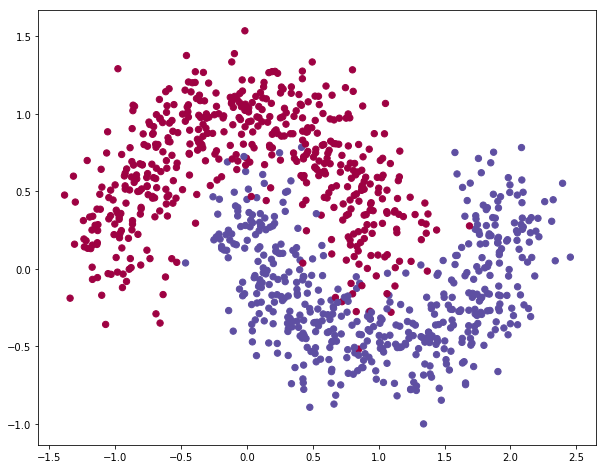

In [5]:
num_classes = 2
X, y = generate_data()
X = X.transpose() # X_dim x Samples
y = np.asarray([to_categorical(i, num_classes) for i in y])
y = np.squeeze(y, axis=1)
y = y.transpose()
print(y.shape)

Consider the following feed-forward neural network with 2 input and output neurons and 3 hidden neurons.

### 3 layer feed-forward neural network
<img src="./images/ffna.png" height=50%, width=50%>

In [27]:
class NeuralNet():
    def __init__(self, X, y, in_dim, hid_dim, out_dim, epochs):
        self.X = X        
        self.y = y        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim        
        self.epochs = epochs        
        self.reg_lambda = 0.01
        self.epsilon = 0.01
        # Weight dimension = nodes(weights_going_to_layer) x nodes(weights_coming_from_layer)
        # W1 - connection between hidden layer and input layer
        #    - nodes(weights_going_to_layer) = nodes(hidden layer)
        #    - nodes(weights_coming_from_layer) = nodes(input layer)
        #    - dim(W1) = nodes(hidden_layer) x nodes(input layer)
        self.model = {
            'W1': np.random.randn(hid_dim, in_dim),
            'b1': np.zeros((hid_dim, 1)),
            'W2': np.random.randn(out_dim, hid_dim),
            'b2': np.zeros((out_dim, 1))
        }
                
    # Sigmoid activation
    @staticmethod
    def activation(x):
        return 1/(1 + np.exp(-x))

    # Sigmoid activation derivative
    def activation_(self, x): 
        return self.activation(x) * (1 - self.activation(x))
    
    # Find error in the last layer
    @staticmethod
    def find_error(prediction, actual):
        return prediction - actual
    
    def forward_pass(self, X_mb):
        self.A0 = X_mb
        self.Z1 = self.model['W1'].dot(self.A0) + self.model['b1']
        self.A1 = self.activation(self.Z1)

        self.Z2 = self.model['W2'].dot(self.A1) + self.model['b2']
        self.A2 = self.activation(self.Z2)
    
        return self.A2
        
    def backpropogate(self, error): 
        # Element wise multiplication
        self.delta2 = np.multiply(error, self.activation_(self.Z2))
        #print('Delta2', self.delta2.shape)
        #print('W2', self.model['W2'].shape)
        
        self.delta1 = np.multiply(np.dot(self.model['W2'].transpose(), self.delta2), self.activation_(self.Z1))
        #print('Delta1', self.delta1.shape)
        
        dW2 = np.dot(self.delta2, self.A1.transpose())
        #print('dW2', dW2.shape)
        db2 = np.mean(self.delta2, axis=1)
        db2 = np.expand_dims(db2, axis=1)
        #print('db2', db2.shape)
        
        dW1 = np.dot(self.delta1, self.A0.transpose())
        db1 = np.mean(self.delta1, axis=1)
        db1 = np.expand_dims(db1, axis=1)
        
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += self.reg_lambda * self.model['W2']
        dW1 += self.reg_lambda * self.model['W1']
        
        # Gradient descent parameter update
        self.model['W2'] += -self.epsilon * dW2
        self.model['b2'] += -self.epsilon * db2
        
        self.model['W1'] += -self.epsilon * dW1
        self.model['b1'] += -self.epsilon * db1
        
    def calculate_loss(self):
        prediction = self.forward_pass(self.X)
        # Calculate cross entropy loss
        loss = np.sum(np.sum(-np.multiply(self.y, np.log(prediction)), axis=0)) / y.shape[1]
        return loss
                  
    def train(self):
        batch_size = 100
        for epoch_num in range(self.epochs):
            #print('Epoch ', epoch_num)
            # Shuffle sample for each epoch of training
            self.X = self.X.transpose()
            self.y = self.y.transpose()
            #print(X.shape, y.shape)
            self.X, self.y = shuffle(self.X, self.y)            
            self.X = self.X.transpose()
            self.y = self.y.transpose()
            #print(X.shape, y.shape)            
            for batch_num in range(int(X.shape[1]/batch_size)):    
                #print(batch_num)
                X_batch = X[:, batch_num * batch_size : (batch_num+1) * batch_size]
                y_batch = y[:, batch_num * batch_size : (batch_num+1) * batch_size]
                #print('X batch', X_batch.shape)
                #print('Y batch', y_batch.shape)
                prediction = self.forward_pass(X_batch)
                #print('Prediction', prediction.shape)
                error = self.find_error(prediction, y_batch)
                #print('Error', error.shape)
                self.backpropogate(error)
            if epoch_num % 100 == 0:
                print('Loss in epcoh %f, batch %f is %f' % (epoch_num, batch_num, self.calculate_loss()))

In [28]:
nn = NeuralNet(in_dim=2, hid_dim=3, out_dim=2, epochs=15000, X=X, y=y)
nn.train()

Loss in epcoh 0.000000, batch 9.000000 is 0.860950
Loss in epcoh 100.000000, batch 9.000000 is 0.308089
Loss in epcoh 200.000000, batch 9.000000 is 0.304217
Loss in epcoh 300.000000, batch 9.000000 is 0.303307
Loss in epcoh 400.000000, batch 9.000000 is 0.302718
Loss in epcoh 500.000000, batch 9.000000 is 0.302303
Loss in epcoh 600.000000, batch 9.000000 is 0.302011
Loss in epcoh 700.000000, batch 9.000000 is 0.301801
Loss in epcoh 800.000000, batch 9.000000 is 0.301642
Loss in epcoh 900.000000, batch 9.000000 is 0.301514
Loss in epcoh 1000.000000, batch 9.000000 is 0.301399
Loss in epcoh 1100.000000, batch 9.000000 is 0.301288
Loss in epcoh 1200.000000, batch 9.000000 is 0.301171
Loss in epcoh 1300.000000, batch 9.000000 is 0.301044
Loss in epcoh 1400.000000, batch 9.000000 is 0.300904
Loss in epcoh 1500.000000, batch 9.000000 is 0.300754
Loss in epcoh 1600.000000, batch 9.000000 is 0.300598
Loss in epcoh 1700.000000, batch 9.000000 is 0.300441
Loss in epcoh 1800.000000, batch 9.00000